In [1]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multinomial
from typing import List
import seaborn as sns
import ROVfxns as ROV

## system characterisation

M = 5
N = 5

state_1 = ROV.State(2, 0.05, 0.2, 0.05)
state_2 = ROV.State(4, 0.05, 0.05, 0.05)

T = 20
E = 50000
r = 0.0125
vc = 2
fc = 50
pi_tax = 0.2
c_tax = 0.4

# lattice parameters ##

s0_step = 200000

p_1 = 0.5
p_max = 8

s0_1 = 500000
s0_max = 3000000

# lattice construction #

##
p_lower = np.linspace(0.75,1.75,3)
p_centre = np.linspace(2,6,17)
p_high = np.linspace(6.5,9,6)
p_higher = np.array(12)

P_grid = np.append(p_lower,p_centre) 
P_grid = np.append(P_grid,p_high)
P_grid = np.append(P_grid,p_higher)
P_grid = P_grid.tolist()

print(P_grid)

s0_grid = list(range(s0_1, s0_max, s0_step))

S = 2
temp_node = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
node_value = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
Lv = np.full((S,len(P_grid), len(s0_grid), M, N), 0)

# here we store the optimal state n in N conditional on prior state m in M ##

temp_path = np.full((S,len(P_grid), len(s0_grid), M), 0)
temp_path_1 = np.full((S,len(P_grid), len(s0_grid), M), 0)
opt_path = []

cost = np.zeros((M, N))
temp_compare = np.zeros((N))

opt_path = np.full((T,S,len(P_grid), len(s0_grid), M), 0)

## cost of staying in or returning to pre-construction state ##

cost[0, 0] = 0
cost[1, 0] = 1500000
cost[2, 0] = 1500000
cost[3, 0] = 1500000
cost[4, 0] = 1500000

## cost of staying in or returning to half-done ##

cost[0, 1] = 2000
cost[1, 1] = 500
cost[2, 1] = 1000000
cost[3, 1] = 1000000
cost[4, 1] = 1000000

## cost of staying in moving to or returning to operating state ##

cost[0, 2] = 1500000
cost[1, 2] = 2000
cost[2, 2] = 0
cost[3, 2] = 2000
cost[4, 2] = 1500000

## cost of staying in or returning to or moving to mothball state ##

cost[0, 3] = 1000000
cost[1, 3] = 1000000
cost[2, 3] = 2000
cost[3, 3] = 0
cost[4, 3] = 1000000

## cost of staying in or returning to moving to abandoned state ##

cost[0, 4] = 1000000
cost[1, 4] = 1000000
cost[2, 4] = 1000000
cost[3, 4] = 5000
cost[4, 4] = 0



[0.75, 1.25, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 12.0]


In [2]:
for t in range(T):
    for q in range(4):

## M refers to adjacent state, N refers to current state ##

## Quarterly profit at each node ##
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if n == 2:
                                if (80 - (t*4 + q))*E < s0_grid[k]:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + ROV.Profit(E,P_grid[i],vc,fc,pi_tax,c_tax)
                                else:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc
                            else:
                                temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc

## Lagrange Differential at each node ##

## then we loop over lagrange differential for nodes inside the boundary ##
        for s in range(2):
            for i in range(1,len(P_grid) - 1):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if s == 0:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_1.s,state_1.e,state_1.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_1.l*(temp_node[0,i,k,m,n]-temp_node[1,i,k,m,n])
                            else:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_1.s,state_1.e,state_1.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_2.l*(temp_node[1,i,k,m,n]-temp_node[0,i,k,m,n])

## we loop over Lagrange differential for boundary nodes ##

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_1.e,state_1.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_1.l*(temp_node[0,0,k,m,n]-temp_node[1,0,k,m,n])
                        else:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_2.e,state_2.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_2.l*(temp_node[1,0,k,m,n]-temp_node[0,0,k,m,n])

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_1.e,state_1.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_1.l*(temp_node[0,len(P_grid) - 1,k,m,n]-temp_node[1,len(P_grid) - 1,k,m,n])
                        else:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_2.e,state_2.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_2.l*(temp_node[1,len(P_grid) - 1,k,m,n]-temp_node[0,len(P_grid) - 1,k,m,n])

## then we apply Lv to temporary node values ##
        
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + Lv[s,i,k,m,n]

## we apply conditional costs on each state ##   
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - cost[m,n]

## we identify the optimal conditional state n in N for every adjacent state m in M ##
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_compare[n] = temp_node[s,i,k,m,n]
                    temp_path[s,i,k,m] = np.argmax(temp_compare)

                    
## allocate out production constraints ## 
        

    print(temp_path[0,10,5,:])
    print(temp_node[0,10,5,:,:])
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    opt_path[t,s,i,k,m] = temp_path[s,i,k,m]
                    

## we for the next cycle, we adjust option value ##

    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        node_value[s,i,k,m,n] = temp_node[s,i,k,m,(temp_path[s,i,k,m])]
                        temp_node[s,i,k,m,n] = node_value[s,i,k,m,n]
    print(temp_node[0,10,5,:,:])

[0 1 2 3 4]
[[    -196    -2196 -1500196 -1000196 -1000196]
 [-1500196     -696    -2196 -1000196 -1000196]
 [-1500196 -1000196     -196    -2196 -1000196]
 [-1500196 -1000196    -2196     -196    -5196]
 [-1500196 -1000196 -1500196 -1000196     -196]]
[[-196 -196 -196 -196 -196]
 [-696 -696 -696 -696 -696]
 [-196 -196 -196 -196 -196]
 [-196 -196 -196 -196 -196]
 [-196 -196 -196 -196 -196]]
[0 1 2 3 4]
[[    -382    -2382 -1500382 -1000382 -1000382]
 [-1500858    -1358    -2858 -1000858 -1000858]
 [-1500382 -1000382     -382    -2382 -1000382]
 [-1500382 -1000382    -2382     -382    -5382]
 [-1500382 -1000382 -1500382 -1000382     -382]]
[[ -382  -382  -382  -382  -382]
 [-1358 -1358 -1358 -1358 -1358]
 [ -382  -382  -382  -382  -382]
 [ -382  -382  -382  -382  -382]
 [ -382  -382  -382  -382  -382]]
[0 1 2 3 4]
[[    -559    -2559 -1500559 -1000559 -1000559]
 [-1501487    -1987    -3487 -1001487 -1001487]
 [-1500559 -1000559     -559    -2559 -1000559]
 [-1500559 -1000559    -2559   

In [ ]:
print(opt_path[:,1,10,0,:])

In [3]:
## option surface generation ##

opt_surface_0 = temp_node[0,:,:,0,2]
opt_surface_1 = temp_node[1,:,:,1,2]

## surface delta 

opt_surface_delta = (opt_surface_1 - opt_surface_0)
print(opt_surface_1)

[[   -8996    -8993    -8974    -8929    -8829    -8656    -8398    -8039
     -7560    -6948    -5988    -4771    -2871]
 [   -8995    -8986    -8950    -8875    -8737    -8523    -8233    -7859
     -7395    -6848    -6048    -5082    -3642]
 [   -8968    -8862    -8614    -8210    -7654    -6968    -6179    -5316
     -4402    -3455    -2491    -1505     -504]
 [   -8667    -8000    -7007    -5809    -4496    -3139    -1778     -440
       861     2118     3324     4488     5615]
 [   -6794    -4327    -1653      977     3458     5750     7850     9766
     11519    13127    14604    15971    17249]
 [    5689    12672    18639    23662    27892    31469    34521    37146
     39431    41438    43217    44811    46257]
 [   58120    73461    84805    93410   100081   105356   109605   113088
    115993   118455   120570   122412   124042]
 [  118523   146020   164951   178428   188300   195721   201437   205939
    209561   212536   215023   217136   218963]
 [  182736   225335   25

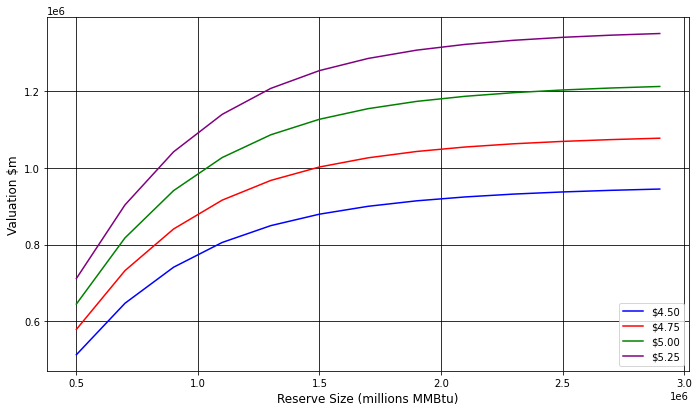

In [18]:
opt_surface_ex1 = temp_node[1,13,:,1,2]
opt_surface_ex2 = temp_node[1,14,:,1,2]
opt_surface_ex3 = temp_node[1,15,:,1,2]
opt_surface_ex4 = temp_node[1,16,:,1,2]

fig = plt.gcf()
fig.set_size_inches(11.5, 6.5)
plt.plot(s0_grid,opt_surface_ex1,color="blue")
plt.plot(s0_grid,opt_surface_ex2,color="red")
plt.plot(s0_grid,opt_surface_ex3,color="green")
plt.plot(s0_grid,opt_surface_ex4,color="purple")
plt.xlabel('Reserve Size (millions MMBtu)', fontsize=12)
plt.ylabel('Valuation $m', fontsize=12)
plt.legend(["$4.50","$4.75","$5.00","$5.25"], loc ="lower right")
plt.grid(color="black")

plt.savefig('/Users/joe/Dropbox/PhD/Writing/TeX/Charts/valuationtest.png', dpi=400)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

s0_grid, P_grid = np.meshgrid(s0_grid,P_grid)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(s0_grid, P_grid, opt_surface_1)
ax.set_zlim(0, 13000000)

plt.show()